In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load ATLAS exclusion curve

In [2]:
atlasCurve = np.genfromtxt('../ATLAS_data/HEPData-ins2080541-v1-csv/MassLimitvs.Lifetime,Chargino,Observed.csv',
                        skip_header=9,
                        names=["Lifetime [ns]","Observed Limit [GeV]","1sigmaPlus","1sigmaMinus"],
                        delimiter=',')
atlasData = pd.read_pickle('../ATLAS_data/charginoData.pcl')
atlasData.rename(columns={'mass (GeV)' : 'mLLP', 'lifetime (ns)' : 'tau_ns', 'width (GeV)' : 'width'},inplace=True)

### Load Recast Data

In [3]:
recastData = pd.read_pickle('../c1c1_c1n1_scan.pcl')
recastData = recastData.round({'tau_ns' : 2, 'mLLP' : 2})
print(len(recastData))

190


In [4]:
# Compute accept*eff for ATLAS
atlasData['totalEff-Low'] = atlasData['acceptance']*atlasData['SR-Inclusive_Low eff']
atlasData['totalEff-High'] = atlasData['acceptance']*atlasData['SR-Inclusive_High eff']
# Get eff for recasting
recastData['totalEff-Low'] = recastData['(SR-Low - no mass Window)'].str[1]
recastData['totalEff-High'] = recastData['(SR-High - no mass Window)'].str[1]

In [5]:
# Get efficiencies
recastPts = recastData[['mLLP','tau_ns','totalEff-Low']].to_numpy()
atlasPts = atlasData[['mLLP','tau_ns','totalEff-Low']].to_numpy()
# Interpolate the recast officiencies to the ATLAS points
effPtsLow = griddata(recastPts[:,:2],recastPts[:,2],atlasPts[:,:2])

In [6]:
effRatio = []
for ipt,pt in enumerate(atlasPts):
    effRecast = effPtsLow[ipt]
    effATLAS = pt[2]
    if np.isnan(effRecast) or not effRecast:
        continue
    if not effATLAS:
        continue
    r = effRecast/effATLAS
    effRatio.append(pt+[r])

In [7]:
# Get efficiencies
recastPtsH = recastData[['mLLP','tau_ns','totalEff-High']].to_numpy()
atlasPtsH = atlasData[['mLLP','tau_ns','totalEff-High']].to_numpy()
# Interpolate the recast officiencies to the ATLAS points
effPtsHigh = griddata(recastPtsH[:,:2],recastPtsH[:,2],atlasPtsH[:,:2])

In [8]:
effRatioH = []
for ipt,pt in enumerate(atlasPtsH):
    effRecast = effPtsHigh[ipt]
    effATLAS = pt[2]
    if np.isnan(effRecast) or not effRecast:
        continue
    if not effATLAS:
        continue
    r = effRecast/effATLAS
    effRatioH.append(pt+[r])

In [9]:
effRatio = np.array(effRatio)
effRatioH = np.array(effRatioH)

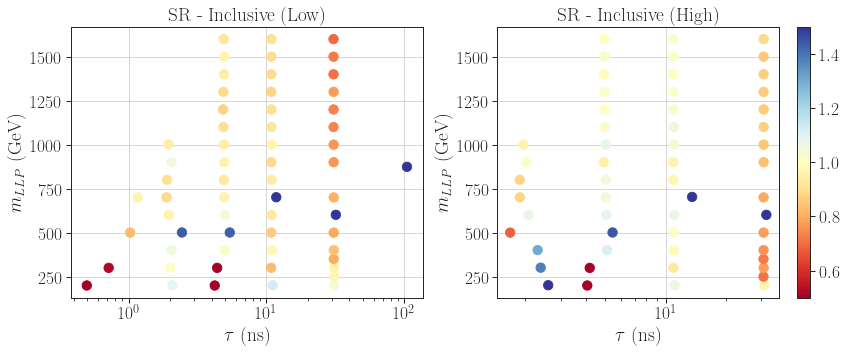

In [10]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))

ax[0].scatter(x=effRatio[:,1],y=effRatio[:,0],vmin=0.5,vmax=1.5,
            c=effRatio[:,2],cmap=cm,s=90)

ax[0].set_ylabel(r'$m_{LLP}$ (GeV)')
ax[0].set_xlabel(r'$\tau$ (ns)')

im = ax[1].scatter(x=effRatioH[:,1],y=effRatioH[:,0],vmin=0.5,vmax=1.5,
            c=effRatioH[:,2],cmap=cm,s=90)

ax[1].set_ylabel(r'$m_{LLP}$ (GeV)')
ax[1].set_xlabel(r'$\tau$ (ns)')


# plt.ylim(500,1200)
# plt.xlim(1,90)
# plt.yticks(np.arange(500.,1200.,100.))
ax[0].grid()
ax[0].set_xscale('log')
ax[0].set_title('SR - Inclusive (Low)')


ax[1].grid()
ax[1].set_xscale('log')
ax[1].set_title('SR - Inclusive (High)')
plt.colorbar(im)
# plt.colorbar(im,label=r'$\mathcal{A}\epsilon$ (Recast)/$\mathcal{A} \epsilon$ (ATLAS)',cax=ax )
# plt.text(0.1,0.7,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
#          transform = plt.gca().transAxes)
# plt.savefig('effRatio.png')
plt.tight_layout()
plt.show()

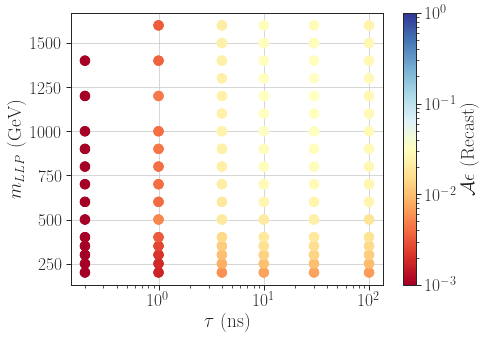

In [11]:
fig = plt.figure(figsize=(7,5))
plt.scatter(x=recastPts[:,1],y=recastPts[:,0],norm=LogNorm(vmin=1e-3,vmax=1e0),
            c=recastPts[:,2],cmap=cm,s=90)
cbar = plt.colorbar(label=r'$\mathcal{A}\epsilon$ (Recast)' )
plt.ylabel(r'$m_{LLP}$ (GeV)')
plt.xlabel(r'$\tau$ (ns)')
# plt.ylim(500,1200)
# plt.xlim(1,90)
# plt.yticks(np.arange(500.,1200.,100.))
plt.grid()
plt.xscale('log')
plt.show()

### Get model points:

In [12]:
pts = list(set((zip(recastData['tau_ns'],recastData['mLLP']))))
muData = []
kfactors = []
# Select minimum mu_obs for each point
for tau,mLLP in pts:
    restData = recastData[(recastData['mLLP'] == mLLP) & (recastData['tau_ns'] == tau)]
    atlasDataR = atlasData[(atlasData['mLLP'] == mLLP) & (atlasData['tau_ns'] == tau)]
    muData.append(restData['$\mu_{obs}$'].min())
#     kfactors.append(atlasDataR['Signal Cross-Section (pb)'].iloc[0]/restData['Total xsec (pb)'].iloc[0])
muData = np.array(muData)
pts = np.array(pts)

In [13]:
kfactor = 1.25
muData = muData/kfactor

### Interpolate for a denser grid

In [14]:
newPts = np.array(list(product(np.linspace(np.log10(pts[:,0].min()), np.log10(pts[:,0].max()),100),
                                      np.linspace(pts[:,1].min(),pts[:,1].max(),100))))
muPts = griddata(list(zip(np.log10(pts[:,0]),pts[:,1])),muData,newPts)
newPts = newPts[~np.isnan(muPts)]
muPts = muPts[~np.isnan(muPts)]

In [15]:
newPts[:,0] = 10**newPts[:,0]

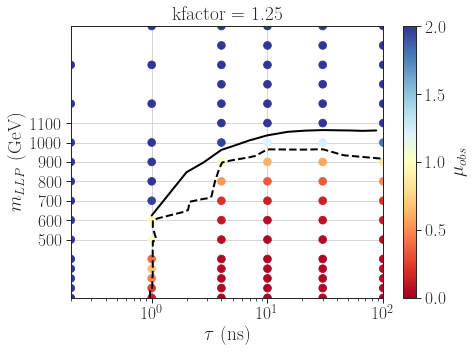

In [16]:
fig = plt.figure(figsize=(7,5))
plt.scatter(x=pts[:,0],y=pts[:,1],vmin=0.0,vmax=2.0,
            c=muData,cmap=cm,s=60)
cbar = plt.colorbar(label=r'$\mu_{obs}$')
plt.plot(atlasCurve["Lifetime_ns"],atlasCurve["Observed_Limit_GeV"],label='ATLAS',linewidth=2,color='black')

# plt.plot(smodelsCurve["tau_ns"],smodelsCurve["mLLP_GeV"],label='ATLAS-2016-32 (SModelS)',linewidth=2,color='gray')

plt.tricontour(newPts[:,0],newPts[:,1],muPts,levels=[1.0],
               linewidths=2,linestyles='dashed',colors='black')
plt.ylabel(r'$m_{LLP}$ (GeV)')
plt.xlabel(r'$\tau$ (ns)')
# plt.ylim(500,1200)
# plt.xlim(0.5,100)
plt.yticks(np.arange(500.,1200.,100.))
plt.grid()
plt.xscale('log')
plt.title('kfactor = %1.2f' %kfactor)
# plt.text(0.1,0.7,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
#          transform = plt.gca().transAxes)
plt.show()

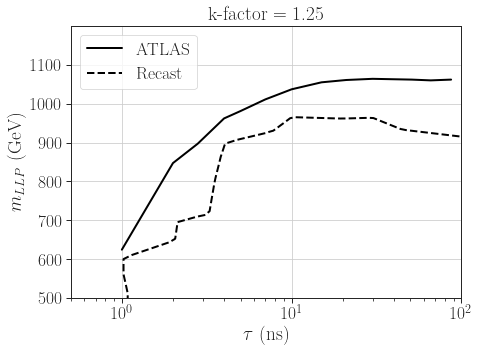

In [17]:
fig = plt.figure(figsize=(7,5))
# plt.scatter(x=pts[:,0],y=pts[:,1],vmin=0.0,vmax=2.0,
#             c=muData,cmap=cm,s=60)
# cbar = plt.colorbar(label=r'$\mu_{obs}$')
plt.plot(atlasCurve["Lifetime_ns"],atlasCurve["Observed_Limit_GeV"],label='ATLAS',linewidth=2,color='black')

cs = plt.tricontour(newPts[:,0],newPts[:,1],muPts,levels=[1.0],
               linewidths=2,linestyles='dashed',colors='black')
#dummy plot
plt.plot([0.0],[0.0],linewidth=2,linestyle='dashed',color='black',label='Recast')

plt.ylabel(r'$m_{LLP}$ (GeV)')
plt.xlabel(r'$\tau$ (ns)')
plt.ylim(500,1200)
plt.xlim(0.5,100)
plt.yticks(np.arange(500.,1200.,100.))
plt.grid()
plt.xscale('log')
plt.title('k-factor = %1.2f' %kfactor)
# plt.text(0.1,0.7,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
#          transform = plt.gca().transAxes)
plt.legend()
plt.savefig('exclusionCurveComp.png')
plt.show()